In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import wind_force, vector_to_xy_components, get_mass_matrix
import pandas as pd

In [ ]:
current_velocity = IntegratedWhiteNoise(0, 0.514, 0.1, 0.001)
current_direction = IntegratedWhiteNoise(0, 360, 100, 1)
wind_velocity = IntegratedWhiteNoise(0, 7.716, 2, 2)
wind_direction = IntegratedWhiteNoise(0, 360, 200, 7)

wind = np.zeros((5, 100))
for i in range(100):
    wind[0, i] = wind_velocity.get_value()
    wind[1, i] = wind_direction.get_value()
    vec = vector_to_xy_components(wind[0, i], wind[1, i])
    wind[2:, i] = wind_force(vec, wind[1, i], np.array([0, 0, 0]))

pd.DataFrame(wind)

In [ ]:
mass_inv = np.linalg.inv(get_mass_matrix())
mass_inv.dot(get_mass_matrix())

In [ ]:
h = 0.01
it = 1000

vel = np.zeros((3, it))
pos = np.zeros((3, it))
pos2 = np.zeros((3, it))

for i in range(it-1):
    v = wind_velocity.get_value()
    d = wind_direction.get_value()
    vec = vector_to_xy_components(v, d)
    f = wind_force(vec, d, vel[:, i])
    force = np.array([100, 0, 0])
    vel[:, i+1] = vel[:, i] + h * mass_inv.dot(force + f)
    
    pos[:, i+1] = pos[:, i] + h * vel[:, i]
    pos2[:, i+1] = pos2[:, i] + h * mass_inv.dot(force + f) * (i*h)

In [ ]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
ax[0, 0].plot(range(it), pos[0, :])
ax[0, 1].plot(range(it), pos[1, :])
ax[0, 2].plot(range(it), pos[2, :])
ax[1, 0].plot(range(it), vel[0, :])
ax[1, 1].plot(range(it), vel[1, :])
ax[1, 2].plot(range(it), vel[2, :])
ax[2, 0].plot(range(it), pos2[0, :])
ax[2, 1].plot(range(it), pos2[1, :])
ax[2, 2].plot(range(it), pos2[2, :])
ax[0, 0].set_title('X-Axis')
ax[0, 1].set_title('Y-Axis')
ax[0, 2].set_title('Z-Moment')

plt.show()

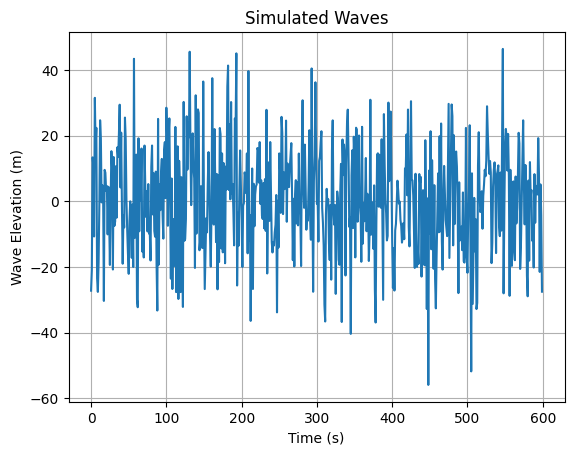

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def pierson_moskowitz_spectrum(f, H_s, T_p):
    """
    Compute the Two-Parameter Pierson–Moskowitz wave spectrum.

    Parameters:
    - f: Frequency array.
    - H_s: Significant wave height.
    - T_p: Peak wave period.

    Returns:
    - Wave energy density per unit frequency interval.
    """
    f_p = 1 / T_p
    return (5/16) * (H_s**2 / T_p**4) * f**(-5) * np.exp(-5/4 * (f / f_p)**(-4))

def simulate_waves(frequencies, H_s, T_p, duration, dt):
    """
    Simulate waves using the random phase method.

    Parameters:
    - frequencies: Frequency array.
    - H_s: Significant wave height.
    - T_p: Peak wave period.
    - duration: Total simulation time.
    - dt: Time step.

    Returns:
    - Time array and simulated wave elevation.
    """
    num_points = int(duration / dt)
    time = np.arange(0, duration, dt)

    # Calculate the spectrum
    spectrum = pierson_moskowitz_spectrum(frequencies, H_s, T_p)

    # Generate random phases
    phases = np.random.rand(len(frequencies), num_points) * 2 * np.pi

    # Combine amplitude, phase, and frequencies to get wave elevation in the time domain
    elevation = np.sum(np.sqrt(2 * spectrum[:, np.newaxis] * dt) * np.cos(2 * np.pi * frequencies[:, np.newaxis] * time + phases), axis=0)

    return time, elevation

# Define simulation parameters
H_s = 3.0        # Significant wave height in meters
T_p = 8.0        # Peak wave period in seconds
duration = 600   # Total simulation time in seconds
dt = 1       # Time step in seconds

# Generate frequency array
frequencies = np.linspace(0.01, 2, 1000)

# Simulate waves
time, wave_elevation = simulate_waves(frequencies, H_s, T_p, duration, dt)

# Plot the simulated wave elevation
plt.plot(time, wave_elevation)
plt.title('Simulated Waves')
plt.xlabel('Time (s)')
plt.ylabel('Wave Elevation (m)')
plt.grid(True)
plt.show()


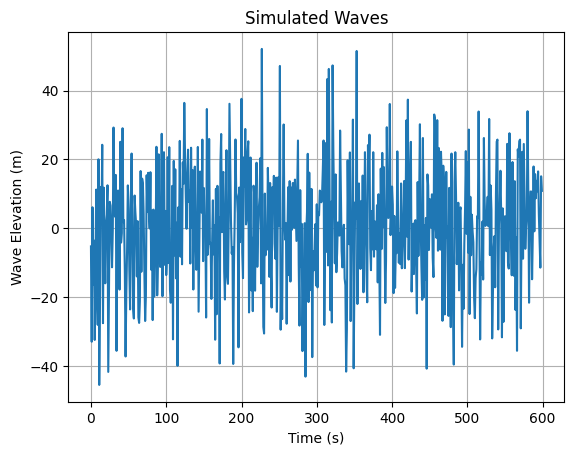

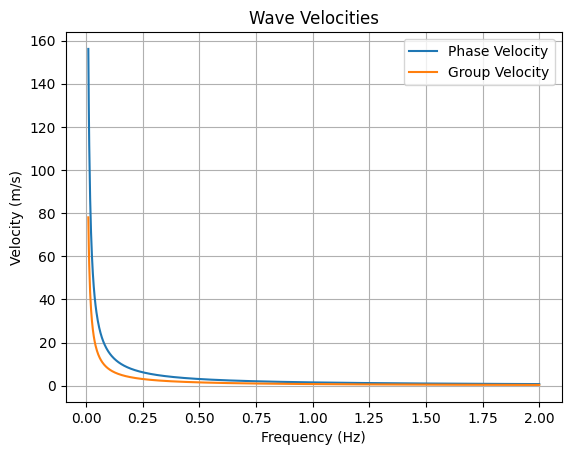

In [29]:
import numpy as np
import matplotlib.pyplot as plt


# Define simulation parameters
H_s = 3.0        # Significant wave height in meters
T_p = 8.0        # Peak wave period in seconds
duration = 600   # Total simulation time in seconds
dt = 1           # Time step in seconds

# Generate frequency array
frequencies = np.linspace(0.01, 2, 1000)

# Simulate waves
time, wave_elevation = simulate_waves(frequencies, H_s, T_p, duration, dt)

# Calculate phase velocity
g = 9.81  # Acceleration due to gravity in m/s^2
wavelength = g / (2 * np.pi * frequencies)**2
phase_velocity = np.sqrt(g * wavelength)

# Calculate group velocity
group_velocity = phase_velocity / 2

# Plot the simulated wave elevation
plt.plot(time, wave_elevation)
plt.title('Simulated Waves')
plt.xlabel('Time (s)')
plt.ylabel('Wave Elevation (m)')
plt.grid(True)
plt.show()

# Plot the calculated velocities
plt.plot(frequencies, phase_velocity, label='Phase Velocity')
plt.plot(frequencies, group_velocity, label='Group Velocity')
plt.title('Wave Velocities')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()


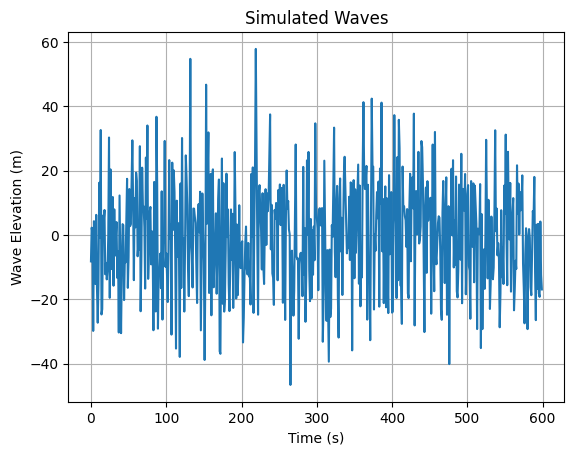

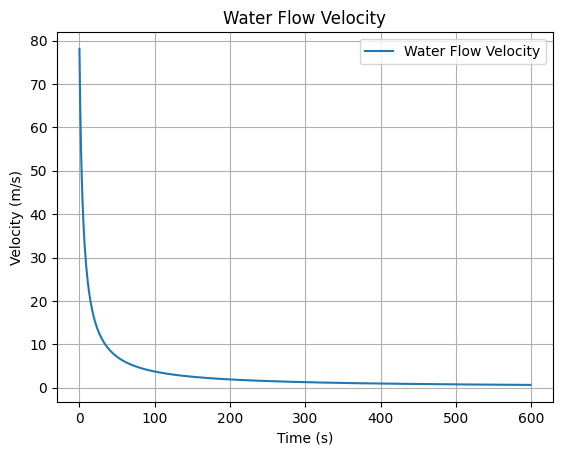

In [40]:
# Define simulation parameters
H_s = 3.0        # Significant wave height in meters
T_p = 8.0        # Peak wave period in seconds
duration = 600   # Total simulation time in seconds
dt = 1           # Time step in seconds

# Generate frequency array
frequencies = np.linspace(0.01, 2, 1000)

# Simulate waves
time, wave_elevation = simulate_waves(frequencies, H_s, T_p, duration, dt)

# Calculate wavelength
g = 9.81  # Acceleration due to gravity in m/s^2
wavelength = g / (2 * np.pi * frequencies)**2

# Initialize arrays for phase velocity and group velocity
phase_velocity = np.zeros_like(wave_elevation)
group_velocity = np.zeros_like(wave_elevation)

# Calculate phase velocity and group velocity at each time step
for i in range(len(time)):
    phase_velocity[i] = np.sqrt(g * wavelength[i])
    group_velocity[i] = phase_velocity[i] / 2

# Plot the simulated wave elevation
plt.plot(time, wave_elevation)
plt.title('Simulated Waves')
plt.xlabel('Time (s)')
plt.ylabel('Wave Elevation (m)')
plt.grid(True)
plt.show()

# Plot the calculated velocities
plt.plot(time, group_velocity, label='Water Flow Velocity')
plt.title('Water Flow Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()


9.665845613735584
11.838194843085542
15.283043825476279
18.083141320025124


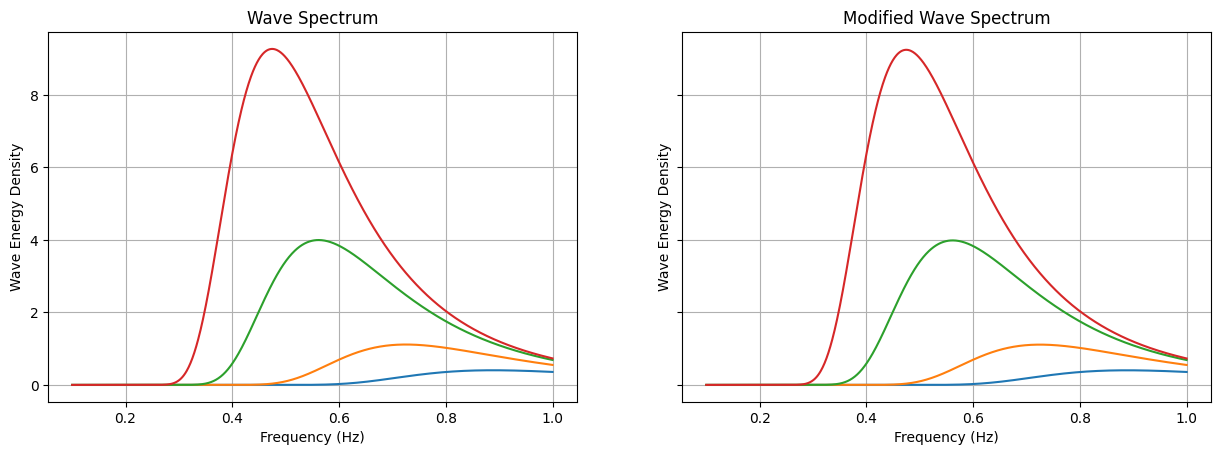

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def modified_spectrum(omega, Hs):    
    g = 9.81
    A = 8.1 * (10**-3) * g**2
    B = 3.11/(Hs**2)
    
    m0 = A/(4*B)
    m1 = 0.306 * (A/(B**(3/4)))
    m2 = (np.sqrt(np.pi)/4)*(A/np.sqrt(B))
    Tz = 2*np.pi*np.sqrt(m0/m2)
    
    first_part = (4 * (np.pi**3) * Hs**2)/((Tz**4)*(omega**5))
    second_part = np.exp((-16*(np.pi**3))/((Tz**4)*(omega**4)))
    return first_part * second_part


def spectrum(omega, Hs):
    g = 9.81
    A = 8.1 * (10**-3) * g**2
    B = 3.11/(Hs**2)
    print(np.sqrt((Hs*g)/0.21))
    return A * (omega**-5) * np.exp(-B*(omega**-4))


# Define simulation parameters
H_s = 3.0        # Significant wave height in meters
T_p = 8.0        # Peak wave period in seconds
a1 = 0.0081      # Parameter for the first term
a2 = 0.006       # Parameter for the second term

# Generate frequency array
frequencies = np.linspace(0.1, 1, 1000)
omegas = 1/frequencies

# Calculate the  spectrum
spectrum_values = spectrum(frequencies, 2)
spectrum_values3 = spectrum(frequencies, 3)
spectrum_values5 = spectrum(frequencies, 5)
spectrum_values7 = spectrum(frequencies, 7)

modified_spectrum_values = modified_spectrum(frequencies, 2)
modified_spectrum_values3 = modified_spectrum(frequencies, 3)
modified_spectrum_values5 = modified_spectrum(frequencies, 5)
modified_spectrum_values7 = modified_spectrum(frequencies, 7)


# Plot the Bretschneider spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.plot(frequencies, spectrum_values)
ax1.plot(frequencies, spectrum_values3)
ax1.plot(frequencies, spectrum_values5)
ax1.plot(frequencies, spectrum_values7)
ax1.set_title('Wave Spectrum')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Wave Energy Density')
ax1.grid(True)

ax2.plot(frequencies, modified_spectrum_values)
ax2.plot(frequencies, modified_spectrum_values3)
ax2.plot(frequencies, modified_spectrum_values5)
ax2.plot(frequencies, modified_spectrum_values7)
ax2.set_title('Modified Wave Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Wave Energy Density')
ax2.grid(True)

fig.set_figwidth(15)
plt.show()
